## Importing Libraries

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

## Loading Raw Dataset

In [99]:
# Use the correct file path to the Excel file in OneDrive
file_path = r'C:\Users\USER\OneDrive - Edge Hill University\Project_Dataset.xlsx'

# Load the main dataset and variable definitions
dataset = pd.read_excel(file_path, sheet_name='Dataset')
variable_definitions = pd.read_excel(file_path, sheet_name='Variable_Definition')

# Display the first few rows of the dataset to understand its structure
dataset.head()

,Sex,Ageatstartofart,ARTStartDate,Duration on ART (Days),Pharmacy_LastPickupdate,DaysOfARVRefill,RegimenLineAtARTStart,RegimenAtARTStart,CurrentRegimenLine,CurrentARTRegimen,...,Educationallevel,MaritalStatus,Employment Status,LastWeight,BP,Whostage,FirstCD4,Days_To_Scheduled Appointment,Appointment_Status,Current_TB_Status
0,Female,36,2020-05-05,1426,2024-03-07,90.0,Adult 1st line ARV regimen,AZT-3TC-NVP,Adult 1st line ARV regimen,TDF-3TC-DTG,...,Secondary school education,Married,Employee,57.0,100/60,1,NaN,54.0,Active With Drugs,No signs or symptoms of disease
1,Male,68,2019-01-08,1909,2023-09-18,180.0,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,...,Secondary school education,Never married,Unemployed,87.0,132/74,1,NaN,-27.0,Missed Appointment,No signs or symptoms of disease
2,Male,68,2019-01-03,1914,2024-01-23,180.0,Adult 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,...,NaN,Widowed,Employee,75.0,100/80,1,NaN,100.0,Active With Drugs,No signs or symptoms of disease
3,Male,13,2019-01-07,1910,2024-02-13,180.0,Child 1st line ARV regimen,TDF-3TC-DTG,Adult 1st line ARV regimen,TDF-3TC-DTG,...,Secondary school education,Married,Student,60.0,0/0,WHO STAGE 1 PEDS,NaN,121.0,Active With Drugs,No signs or symptoms of disease
4,Female,57,2019-01-10,1907,2024-03-28,180.0,Adult 1st line ARV regimen,TDF-3TC-EFV,Adult 1st line ARV regimen,TDF-3TC-DTG,...,Secondary school education,Widowed,Employee,39.0,145/77,1,NaN,165.0,Active With Drugs,No signs or symptoms of disease


## Data Preparation

#### Checking for Missing Values

In [102]:
# Checking for missing values in the dataset
missing_values = dataset.isnull().sum()

# Display the columns with missing values
missing_values[missing_values > 0]


Pharmacy_LastPickupdate            174
DaysOfARVRefill                    179
RegimenLineAtARTStart               17
RegimenAtARTStart                   46
CurrentRegimenLine                  17
CurrentARTRegimen                  221
CurrentViralLoad                  8215
Verbal Autopsy_Cause_of_Death    67396
Educationallevel                 10927
MaritalStatus                     4003
Employment Status                 5559
LastWeight                        1454
BP                                3866
Whostage                            26
FirstCD4                         65238
Days_To_Scheduled Appointment      181
Current_TB_Status                  331
dtype: int64

#### Missing Data Visualisation

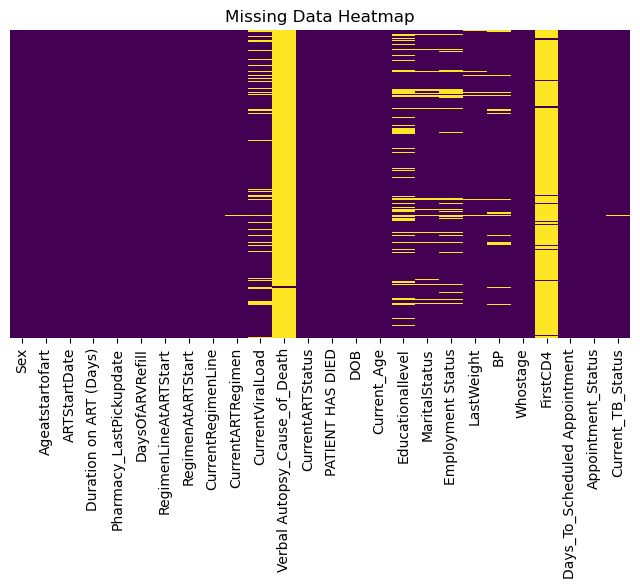

In [104]:
plt.figure(figsize=(8, 4))
sns.heatmap(dataset.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#### Handling Missing Values

In [109]:
# Step 1: Split the BP column into Systolic and Diastolic values (if not already done)
if 'BP' in dataset.columns:
    dataset[['Systolic_BP', 'Diastolic_BP']] = dataset['BP'].str.split('/', expand=True)
    
    # Convert the new columns to numeric values
    dataset['Systolic_BP'] = pd.to_numeric(dataset['Systolic_BP'], errors='coerce')
    dataset['Diastolic_BP'] = pd.to_numeric(dataset['Diastolic_BP'], errors='coerce')
    
    # Impute missing values in these columns with the median
    dataset['Systolic_BP'] = dataset['Systolic_BP'].fillna(dataset['Systolic_BP'].median())
    dataset['Diastolic_BP'] = dataset['Diastolic_BP'].fillna(dataset['Diastolic_BP'].median())
    
    # Drop the original BP column since it's now split into two separate columns
    dataset = dataset.drop(columns=['BP'])

# Step 2: Handle missing values in numerical columns using the median
numerical_columns_to_impute = ['LastWeight', 'CurrentViralLoad', 'DaysOfARVRefill', 'FirstCD4', 'Days_To_Scheduled Appointment']
for col in numerical_columns_to_impute:
    dataset[col] = dataset[col].fillna(dataset[col].median())

# Step 3: Handle missing values in categorical columns using the mode
categorical_columns_to_impute = ['MaritalStatus', 'Educationallevel', 'Employment Status', 
                                 'RegimenLineAtARTStart', 'RegimenAtARTStart', 'CurrentRegimenLine', 
                                 'CurrentARTRegimen', 'Verbal Autopsy_Cause_of_Death', 
                                 'Current_TB_Status', 'Whostage']
for col in categorical_columns_to_impute:
    dataset[col] = dataset[col].fillna(dataset[col].mode()[0])

# Step 4: Forward-fill missing values in date columns (if applicable)
dataset['Pharmacy_LastPickupdate'] = dataset['Pharmacy_LastPickupdate'].ffill()

# Step 5: Check for any remaining missing values after the full imputation
missing_values_after_imputation = dataset.isnull().sum()

# Display missing values for all columns, including those with 0 missing values
print("Missing values after full imputation:")
print(missing_values_after_imputation)


Missing values after full imputation:
Sex                              0
Ageatstartofart                  0
ARTStartDate                     0
Duration on ART (Days)           0
Pharmacy_LastPickupdate          0
DaysOfARVRefill                  0
RegimenLineAtARTStart            0
RegimenAtARTStart                0
CurrentRegimenLine               0
CurrentARTRegimen                0
CurrentViralLoad                 0
Verbal Autopsy_Cause_of_Death    0
CurrentARTStatus                 0
PATIENT HAS DIED                 0
DOB                              0
Current_Age                      0
Educationallevel                 0
MaritalStatus                    0
Employment Status                0
LastWeight                       0
Whostage                         0
FirstCD4                         0
Days_To_Scheduled Appointment    0
Appointment_Status               0
Current_TB_Status                0
Systolic_BP                      0
Diastolic_BP                     0
dtype: int64


## Exploratory Data Analysis - EDA

#### Distribution of Target Variable

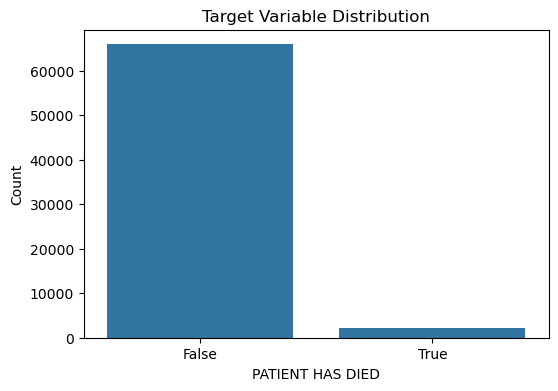

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='PATIENT HAS DIED', data=dataset)
plt.title('Target Variable Distribution')
plt.ylabel('Count')
plt.show()

#### Correlation Matrix:

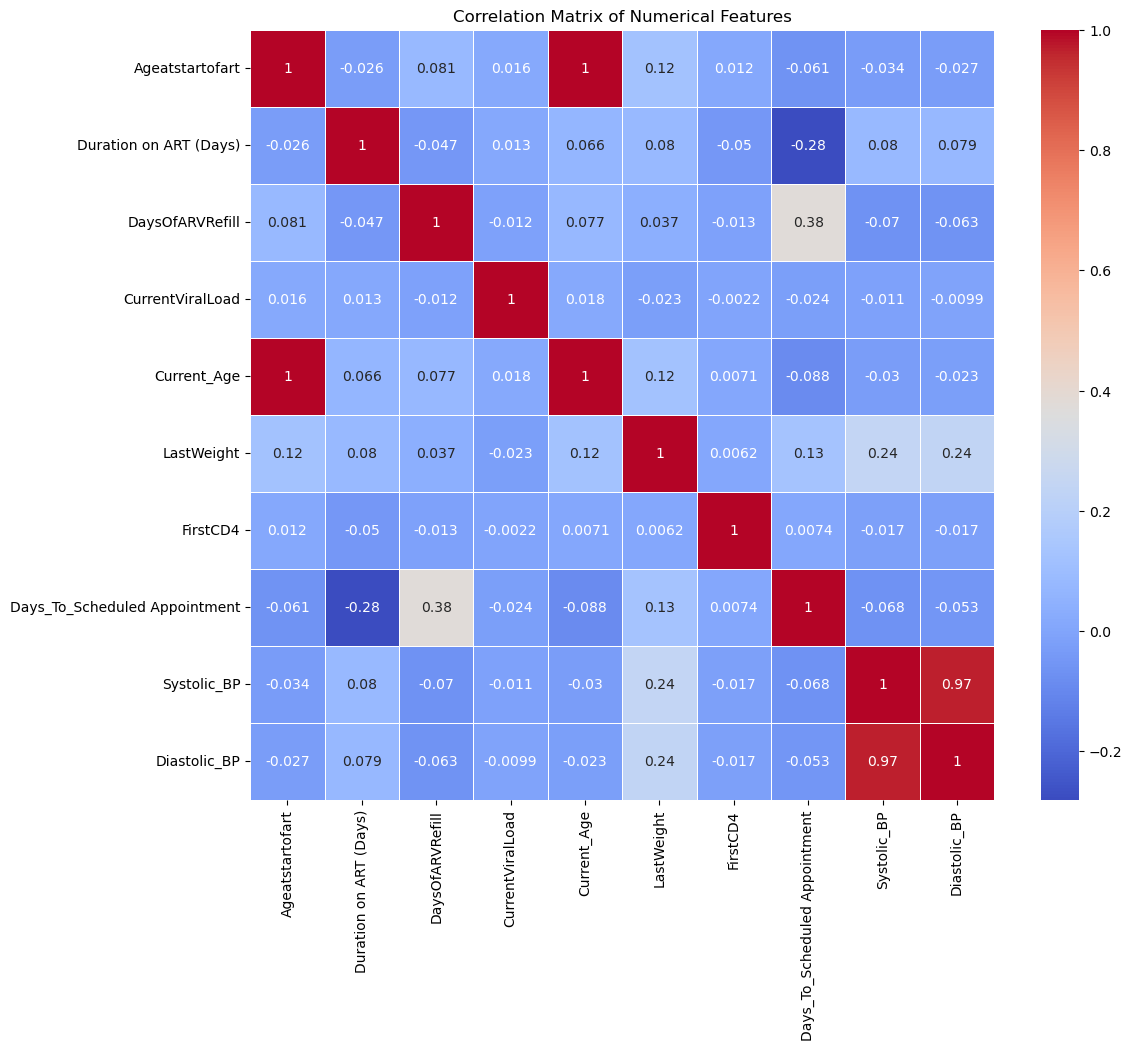

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns from the dataset
numerical_dataset = dataset.select_dtypes(include=[float, int])

# Plot the correlation matrix for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_dataset.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


#### Distribution of Key Numerical Features

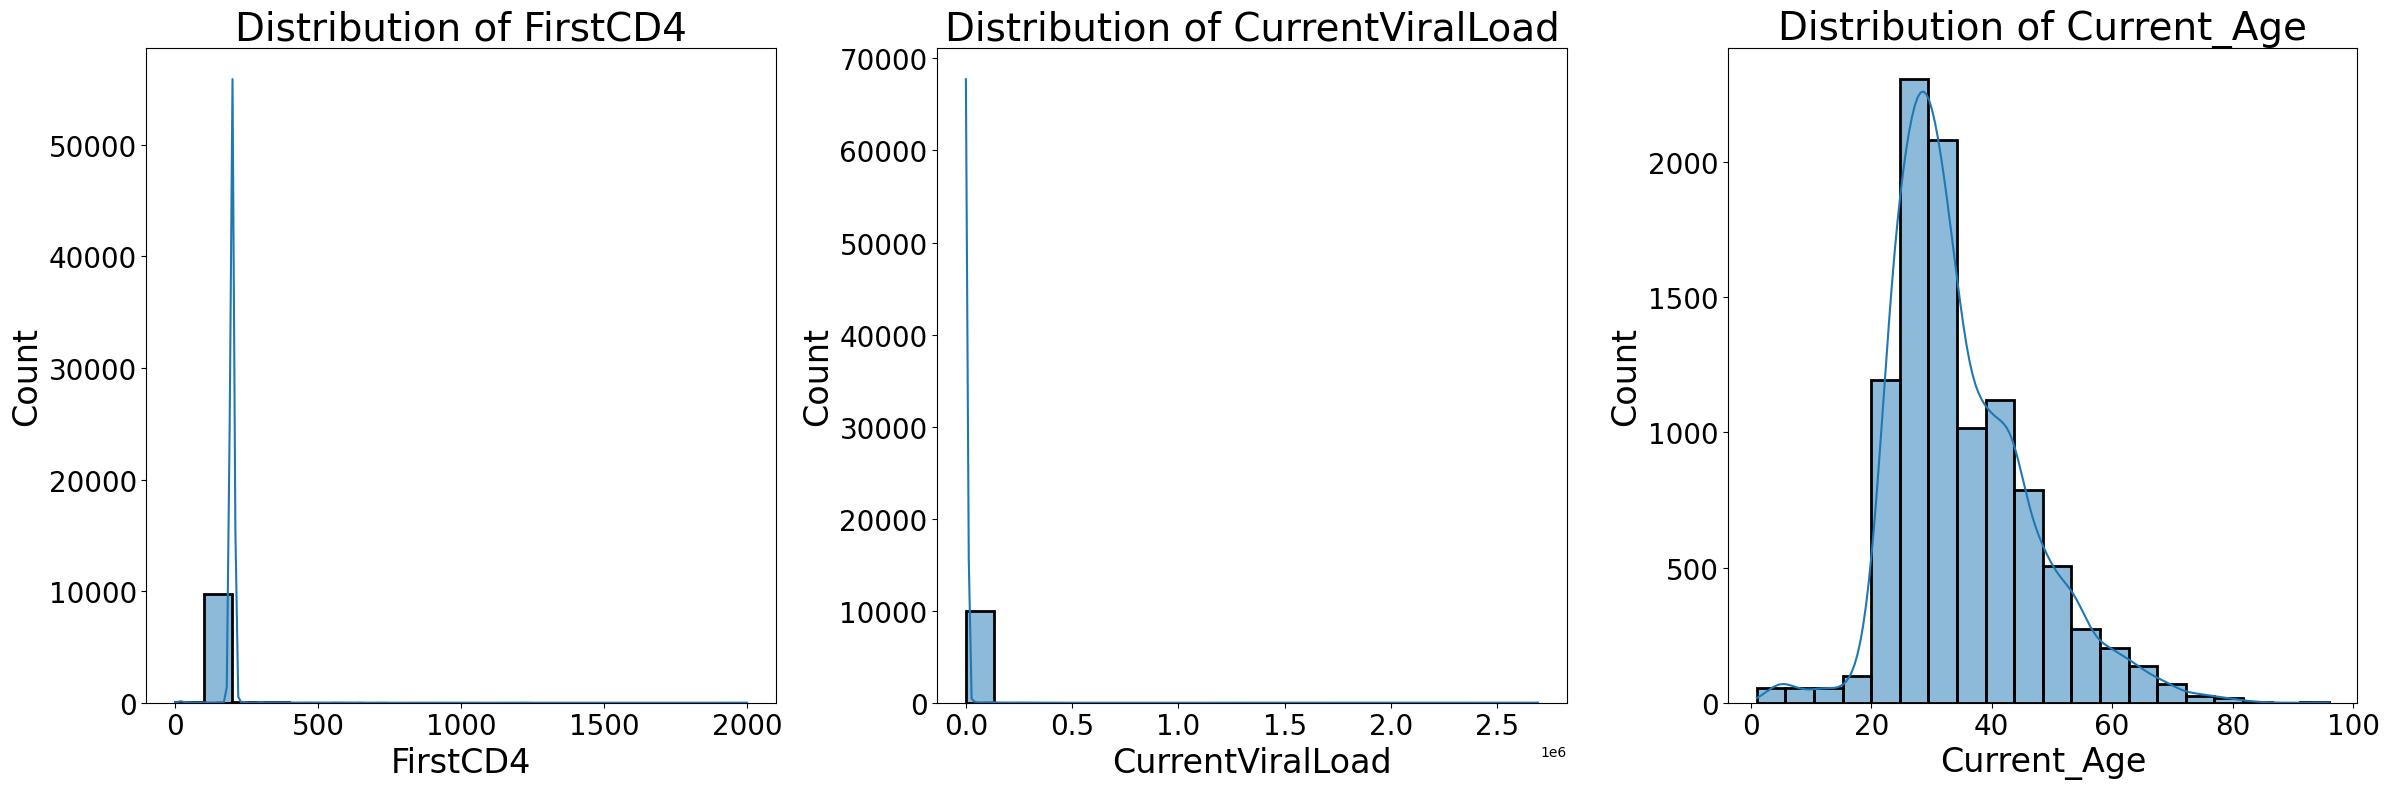

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['FirstCD4', 'CurrentViralLoad', 'Current_Age']

# Sample a subset of the data for faster plotting (e.g., 10,000 rows)
sampled_dataset = dataset.sample(n=10000, random_state=42)

# Set up the figure size and create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Increase the figure size

# Loop over the numerical features and plot histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(sampled_dataset[feature], kde=True, bins=20, ax=axes[i], linewidth=2)  # Adjust bin size and line width
    axes[i].set_title(f'Distribution of {feature}', fontsize=28)  # Increase title font size
    axes[i].set_xlabel(feature, fontsize=24)  # Increase x-axis label font size
    axes[i].set_ylabel('Count', fontsize=24)  # Increase y-axis label font size
    axes[i].tick_params(axis='both', labelsize=20)  # Increase the font size for tick labels

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


#### 4. Boxplots to identify Outliers

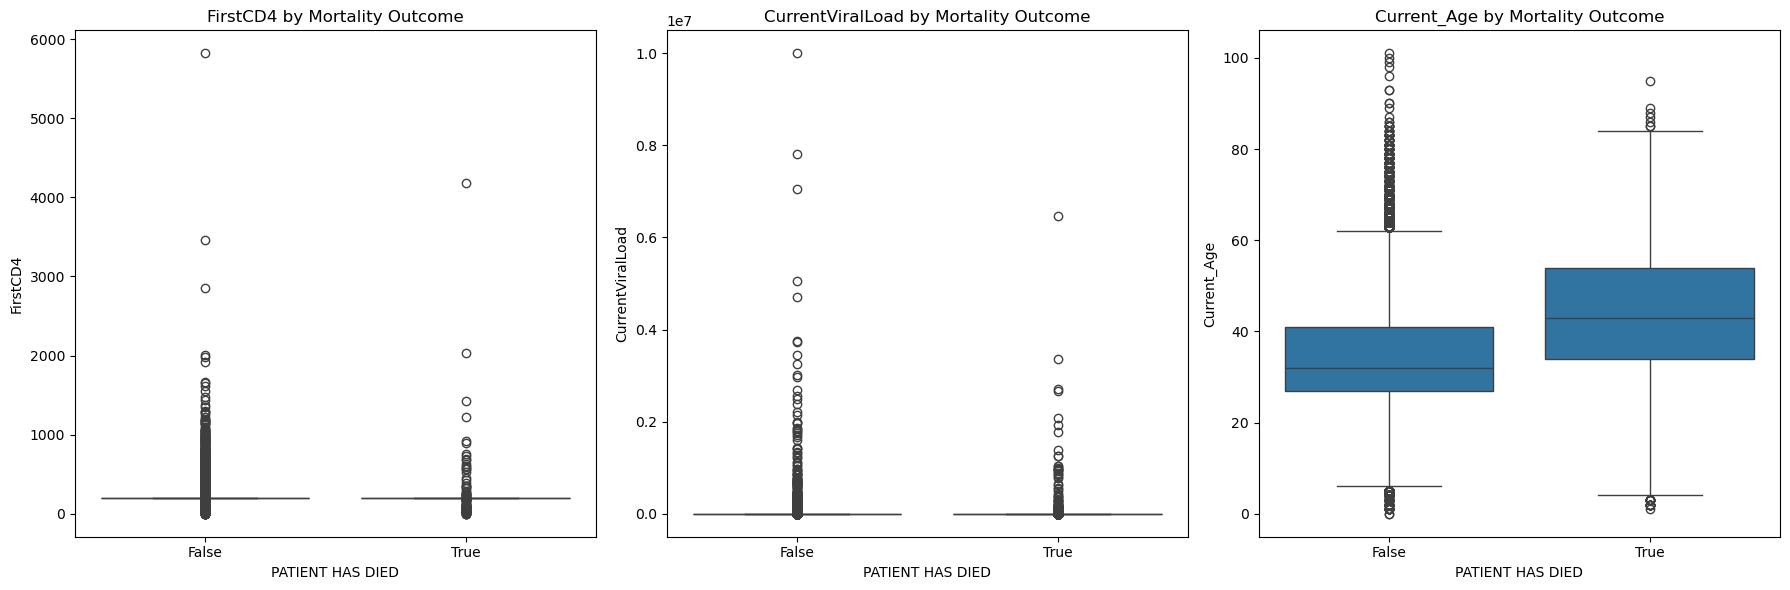

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='PATIENT HAS DIED', y=feature, data=dataset, ax=axes[i])
    axes[i].set_title(f'{feature} by Mortality Outcome')

plt.tight_layout()
plt.show()

#### 5. Categorical Feature Analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_1904\3330054273.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=feature, y='PATIENT HAS DIED', data=dataset, ax=axes[i], ci=None)  # ci=None removes error bars
C:\Users\USER\AppData\Local\Temp\ipykernel_1904\3330054273.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better fit
C:\Users\USER\AppData\Local\Temp\ipykernel_1904\3330054273.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=feature, y='PATIENT HAS DIED', data=dataset, ax=axes[i], ci=None)  # ci=None removes error bars
C:\Users\USER\AppData\Local\Temp\ipykernel_1904\3330054273.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

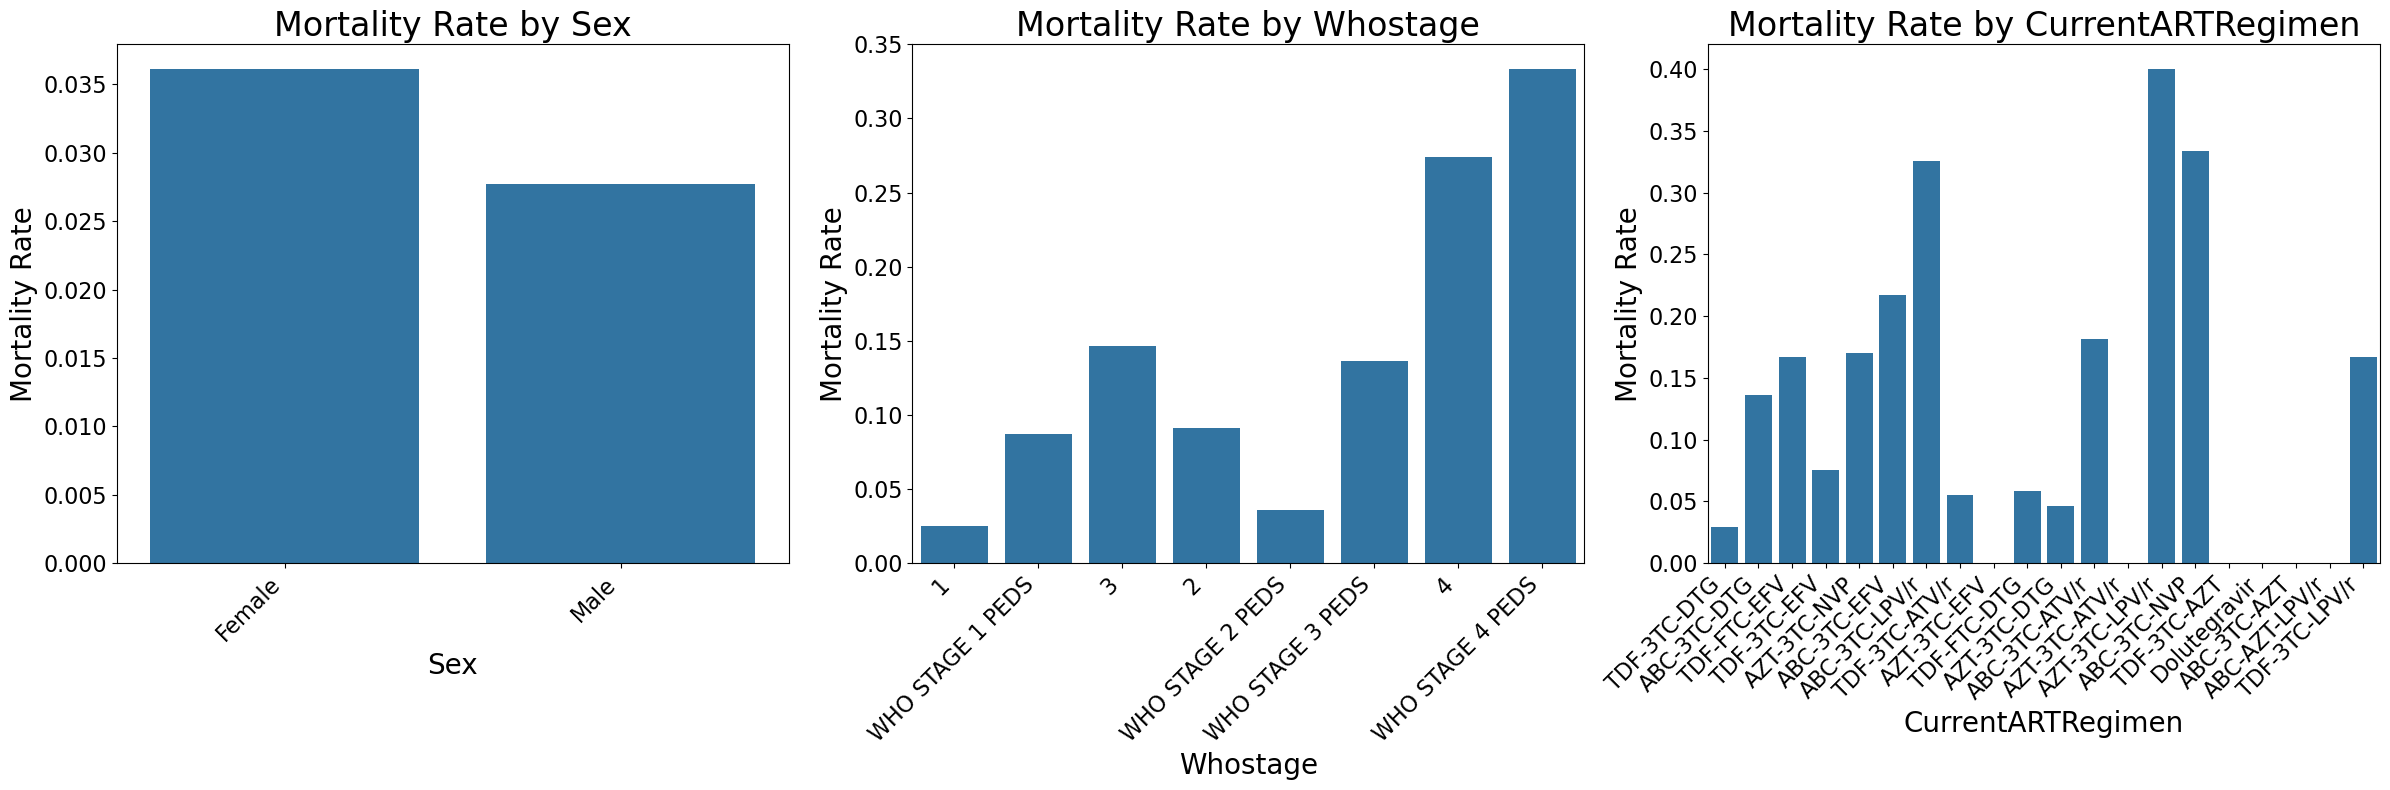

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the categorical features for comparison
categorical_features = ['Sex', 'Whostage', 'CurrentARTRegimen']

# Set up the figure size and subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Increase figure size for better visibility

# Loop through each categorical feature and plot a bar chart
for i, feature in enumerate(categorical_features):
    sns.barplot(x=feature, y='PATIENT HAS DIED', data=dataset, ax=axes[i], ci=None)  # ci=None removes error bars
    axes[i].set_title(f'Mortality Rate by {feature}', fontsize=24)  # Increase title font size
    axes[i].set_xlabel(feature, fontsize=20)  # Increase x-axis label font size
    axes[i].set_ylabel('Mortality Rate', fontsize=20)  # Adjust y-axis label
    axes[i].tick_params(axis='x', labelsize=16)  # Increase the x-axis tick label size
    axes[i].tick_params(axis='y', labelsize=16)  # Increase the y-axis tick label size
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better fit

# Adjust layout to ensure no overlaps
plt.tight_layout()

# Show the plot
plt.show()


#### Time-based Analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_1904\2064336686.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mortality_rate_monthly = dataset['PATIENT HAS DIED'].resample('M').mean()


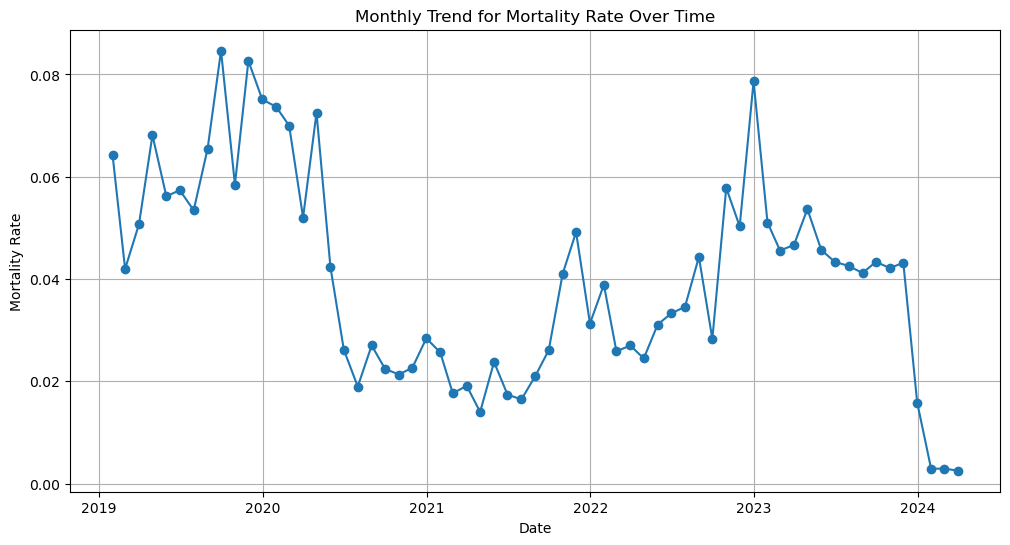

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'ARTStartDate' is in datetime format
dataset['ARTStartDate'] = pd.to_datetime(dataset['ARTStartDate'])

# Set 'ARTStartDate' as the index to facilitate resampling
dataset.set_index('ARTStartDate', inplace=True)

# Resample the data monthly and calculate the mean mortality rate per month
mortality_rate_monthly = dataset['PATIENT HAS DIED'].resample('M').mean()

# Plot the monthly mortality rate over time
plt.figure(figsize=(12, 6))
plt.plot(mortality_rate_monthly.index, mortality_rate_monthly, marker='o', linestyle='-')
plt.title('Monthly Trend for Mortality Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Mortality Rate')
plt.grid(True)
plt.show()


#### Boxplot to Detect and Handle Outliers

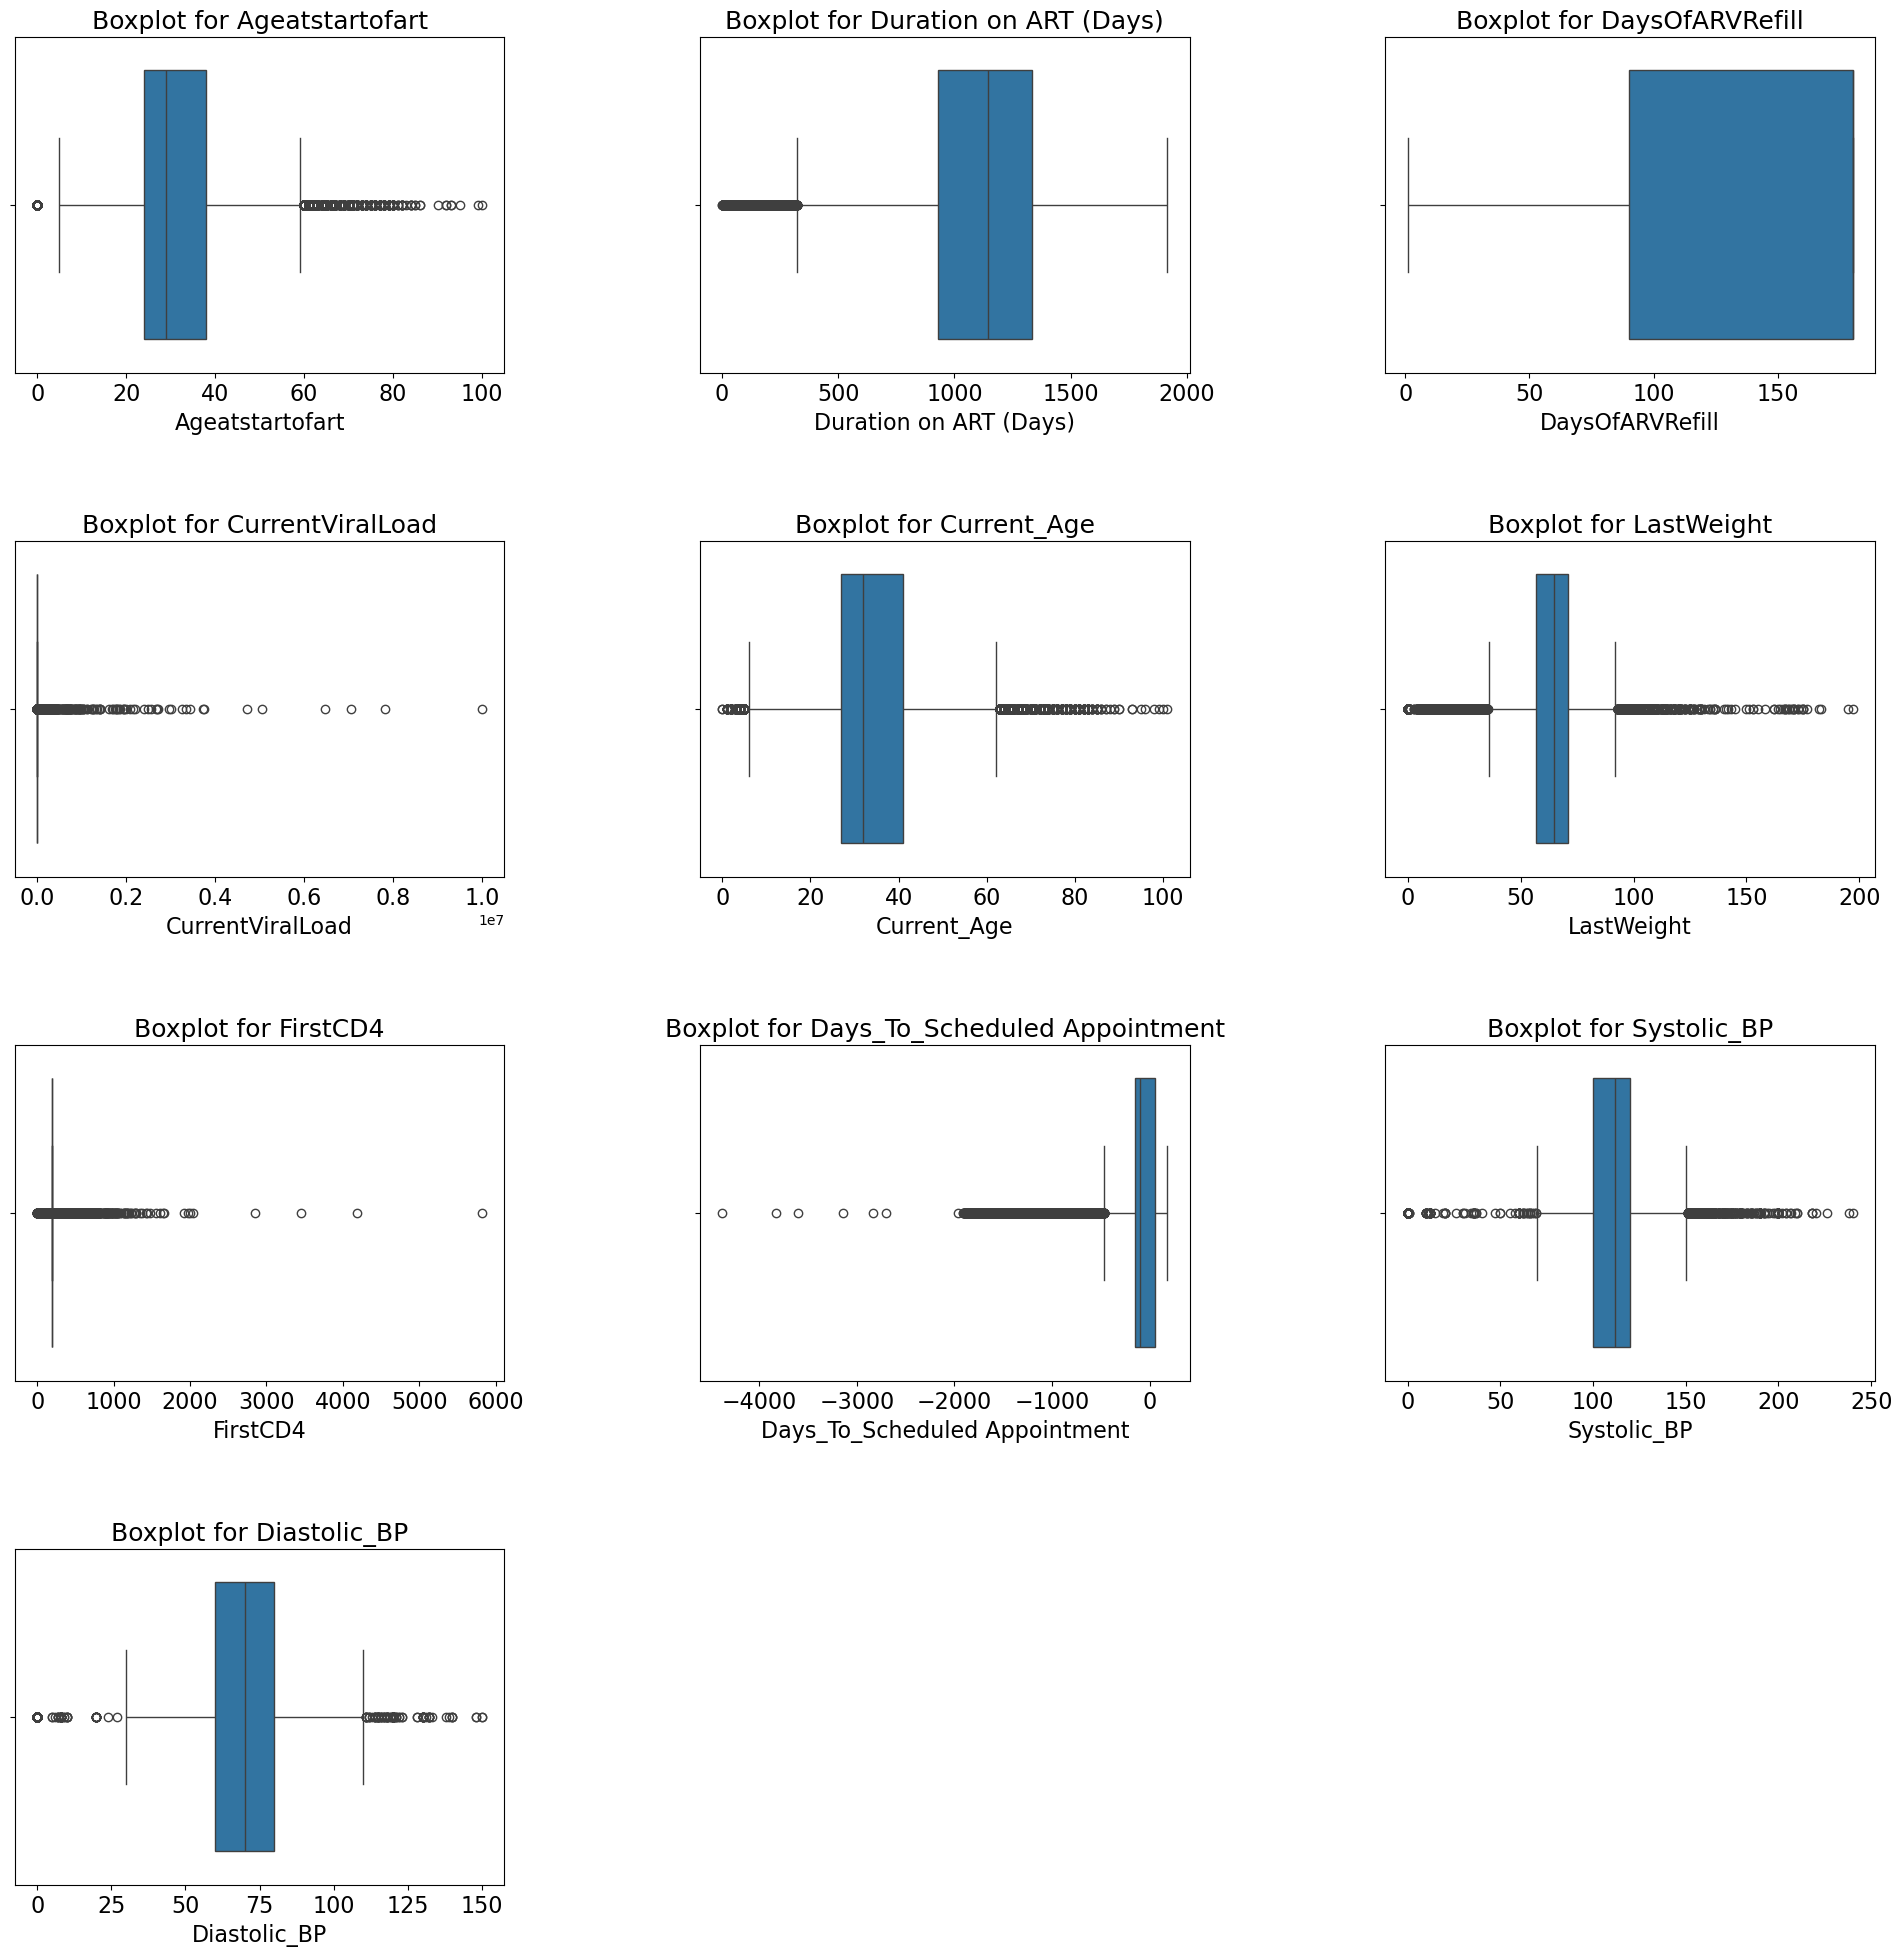

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get numerical columns
numerical_columns = dataset.select_dtypes(include=[np.number]).columns

# Set up the number of rows and columns for subplots (side by side layout)
n_cols = 3  # Reduced number of columns for larger subplots
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24, n_rows * 6))  # Larger figure size
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Adjust space between plots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each numerical column and create a boxplot
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=dataset[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}', fontsize=18)  # Increase title font size
    axes[i].set_xlabel(column, fontsize=16)  # Increase x-axis label font size
    axes[i].tick_params(axis='both', which='major', labelsize=16)  # Increase tick font size
    
# Hide any empty subplots (if the number of plots is less than the grid size)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Show the plot with all boxplots in one figure
plt.show()


#### Handling Outliers

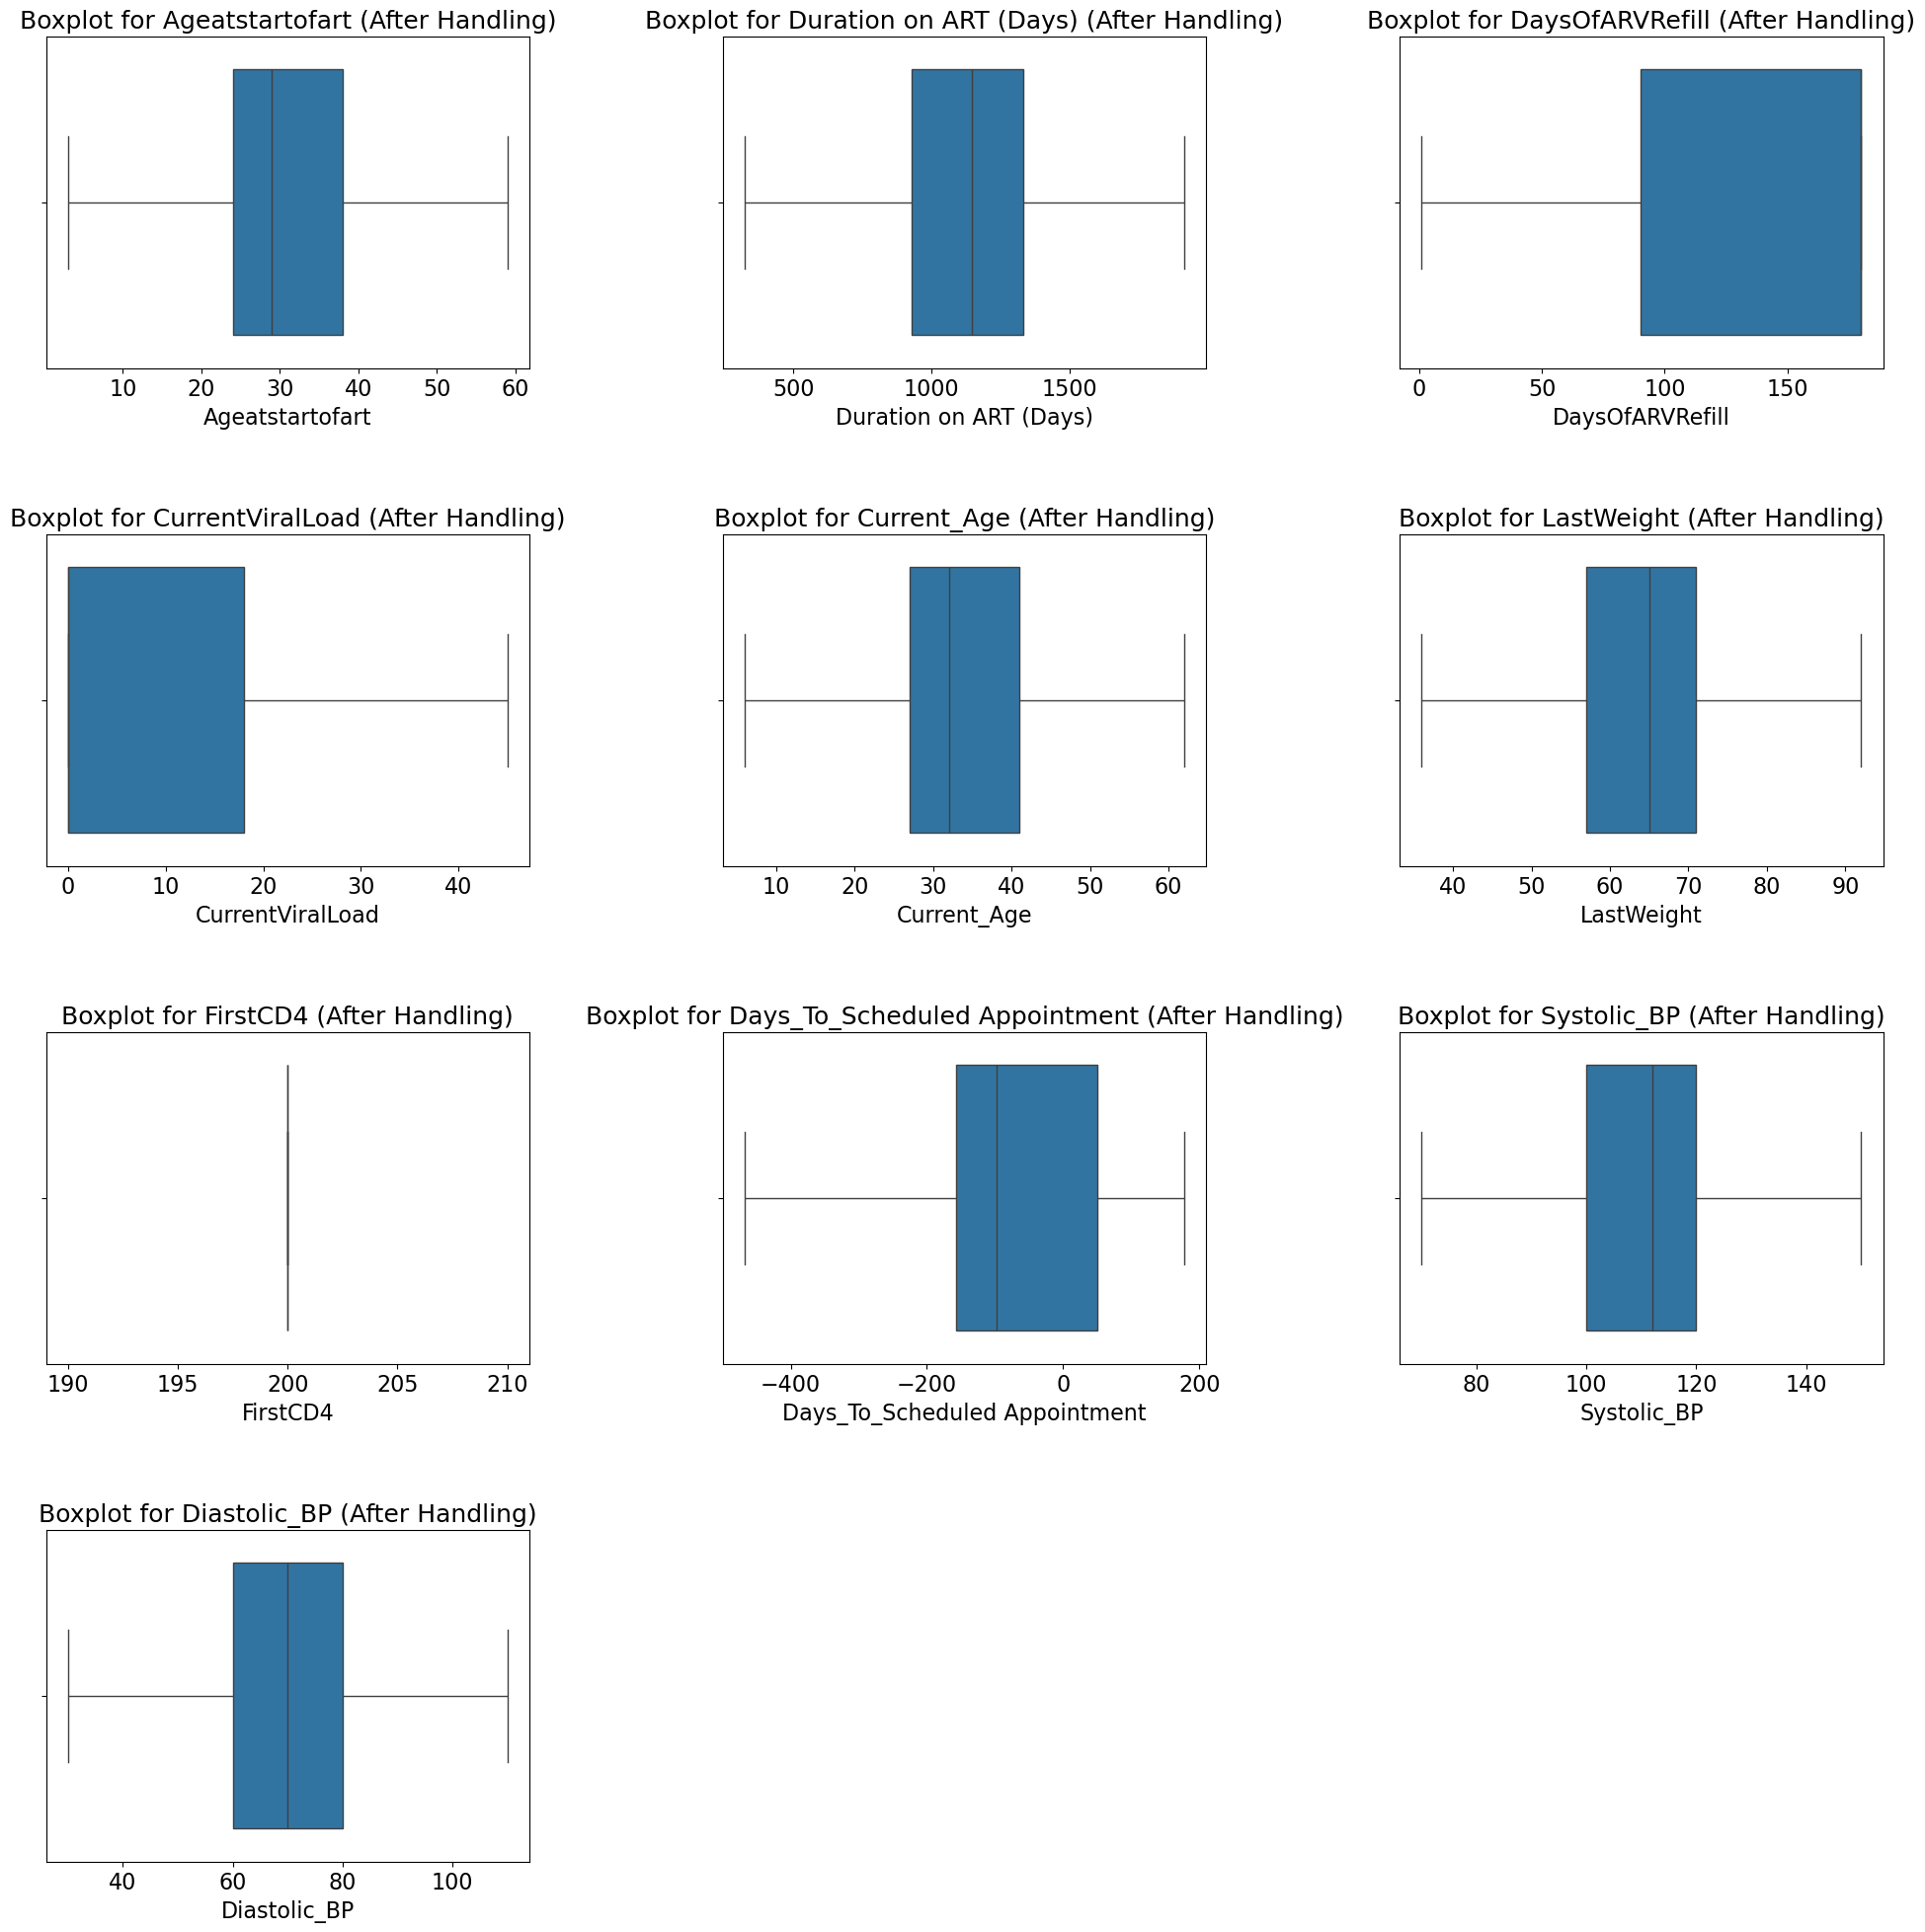

In [135]:
# Handle outliers using the IQR method
def handle_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers at the boundaries
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Apply outlier handling to all numerical columns
for col in numerical_columns:
    handle_outliers_iqr(dataset, col)

# Set up the number of rows and columns for subplots (side by side layout)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24, n_rows * 6))  # Larger figure size
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Adjust space between plots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through each numerical column and create a boxplot to visualize after handling outliers
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=dataset[column], ax=axes[i])
    axes[i].set_title(f'Boxplot for {column} (After Handling)', fontsize=18)  # Increase title font size
    axes[i].set_xlabel(column, fontsize=16)  # Increase x-axis label font size
    axes[i].tick_params(axis='both', which='major', labelsize=16)  # Increase tick font size

# Hide any empty subplots (if the number of plots is less than the grid size)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Show the plot with all boxplots in one figure
plt.show()


## Feature Scaling

#### Handling Class Imbalance and Splitting of dataset

In [142]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate the features and target variable
features = dataset.drop(columns=['PATIENT HAS DIED', 'Pharmacy_LastPickupdate', 'DOB'])  # Drop irrelevant columns
target = dataset['PATIENT HAS DIED']  # Define target column

# Convert categorical features to dummy variables
features_encoded = pd.get_dummies(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the balance after resampling
print(y_train_resampled.value_counts())


PATIENT HAS DIED
False    52676
True     52676
Name: count, dtype: int64


## Model Training

#### Feature Importance Engineering

In [146]:
# Columns to drop due to potential data leakage and redundancy
columns_to_drop = [
    'Pharmacy_LastPickupdate',  # Date-related, possibly tied to death
    'DaysOfARVRefill',          # Could reveal information about whether patient is alive
    'Appointment_Status',       # Could be tied to mortality through missed appointments
    'DOB',                      # Date of birth might be tied to age-related effects on death, but could be redundant
    'CurrentARTStatus'          # Likely contains status like "active," "inactive," which could directly correlate with death
    'RegimenLineAtARTStart', 'RegimenAtARTStart', 'CurrentRegimenLine',
    'CurrentARTRegimen', 'CurrentViralLoad',
    'Verbal Autopsy_Cause_of_Death',
]

# Drop the potential leakage columns
features_refined = dataset.drop(columns=['PATIENT HAS DIED'] + columns_to_drop, errors='ignore')  # Use errors='ignore' in case columns are not found

# Check if the columns were dropped
print("Columns after dropping leakage-related columns:")
print(features_refined.columns)

# Encode the remaining categorical variables
features_refined_encoded = pd.get_dummies(features_refined)

# Train-test split
X_train_refined, X_test_refined, y_train_refined, y_test_refined = train_test_split(
    features_refined_encoded, dataset['PATIENT HAS DIED'], test_size=0.2, random_state=42
)

# Apply SMOTE to the refined training data
smote = SMOTE(random_state=42)
X_train_resampled_refined, y_train_resampled_refined = smote.fit_resample(X_train_refined, y_train_refined)

# Re-train the model with the refined feature set
log_reg_refined = LogisticRegression(max_iter=1000, random_state=42, penalty='l2', C=1.0)
log_reg_refined.fit(X_train_resampled_refined, y_train_resampled_refined)

# Evaluate on the test set
y_pred_logreg_refined = log_reg_refined.predict(X_test_refined)
roc_auc_logreg_refined = roc_auc_score(y_test_refined, log_reg_refined.predict_proba(X_test_refined)[:, 1])

# Output the results
print(f"Refined Model Test Set ROC AUC: {roc_auc_logreg_refined}")


Columns after dropping leakage-related columns:
Index(['Sex', 'Ageatstartofart', 'Duration on ART (Days)',
       'RegimenLineAtARTStart', 'CurrentARTStatus', 'Current_Age',
       'Educationallevel', 'MaritalStatus', 'Employment Status', 'LastWeight',
       'Whostage', 'FirstCD4', 'Days_To_Scheduled Appointment',
       'Current_TB_Status', 'Systolic_BP', 'Diastolic_BP'],
      dtype='object')
Refined Model Test Set ROC AUC: 1.0


### Logistic Regression

In [153]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the resampled training data
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled_refined)

# Transform the test data
X_test_scaled = scaler.transform(X_test_refined)

# Re-train the logistic regression model on the scaled data
log_reg_refined = LogisticRegression(max_iter=5000, random_state=42, penalty='l2', C=1.0)
log_reg_refined.fit(X_train_resampled_scaled, y_train_resampled_refined)

# Evaluate on the scaled test data
y_pred_logreg_refined = log_reg_refined.predict(X_test_scaled)
roc_auc_logreg_refined = roc_auc_score(y_test_refined, log_reg_refined.predict_proba(X_test_scaled)[:, 1])

# Output the results
print(f"Refined Model Test Set ROC AUC: {roc_auc_logreg_refined}")


Refined Model Test Set ROC AUC: 0.9999999999999999


In [53]:
# Re-train the Logistic Regression model with class weights
log_reg_weighted = LogisticRegression(max_iter=5000, random_state=42, penalty='l2', C=1.0, class_weight='balanced')
log_reg_weighted.fit(X_train_resampled_scaled, y_train_resampled_refined)

# Make predictions on the test set
y_pred_logreg_weighted = log_reg_weighted.predict(X_test_scaled)

# Evaluate the model
accuracy_logreg_weighted = accuracy_score(y_test_refined, y_pred_logreg_weighted)
precision_logreg_weighted = precision_score(y_test_refined, y_pred_logreg_weighted)
recall_logreg_weighted = recall_score(y_test_refined, y_pred_logreg_weighted)
f1_logreg_weighted = f1_score(y_test_refined, y_pred_logreg_weighted)
roc_auc_logreg_weighted = roc_auc_score(y_test_refined, log_reg_weighted.predict_proba(X_test_scaled)[:, 1])

# Print out all the performance metrics
print("Logistic Regression (Class Weighted) Model Performance:")
print(f"Accuracy: {accuracy_logreg_weighted}")
print(f"Precision: {precision_logreg_weighted}")
print(f"Recall: {recall_logreg_weighted}")
print(f"F1-Score: {f1_logreg_weighted}")
print(f"ROC AUC: {roc_auc_logreg_weighted}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_logreg_weighted))


Logistic Regression (Class Weighted) Model Performance:
Accuracy: 0.9736958119030125
Precision: 0.5924528301886792
Recall: 0.3857493857493858
F1-Score: 0.46726190476190477
ROC AUC: 0.9334255244275693

Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     13203
        True       0.59      0.39      0.47       407

    accuracy                           0.97     13610
   macro avg       0.79      0.69      0.73     13610
weighted avg       0.97      0.97      0.97     13610



In [55]:
import numpy as np

# Predict probabilities for the test set
y_proba_logreg = log_reg_weighted.predict_proba(X_test_scaled)[:, 1]

# Set a custom threshold (e.g., 0.3)
threshold = 0.3
y_pred_logreg_custom = np.where(y_proba_logreg >= threshold, 1, 0)

# Evaluate the model with the custom threshold
accuracy_logreg_custom = accuracy_score(y_test_refined, y_pred_logreg_custom)
precision_logreg_custom = precision_score(y_test_refined, y_pred_logreg_custom)
recall_logreg_custom = recall_score(y_test_refined, y_pred_logreg_custom)
f1_logreg_custom = f1_score(y_test_refined, y_pred_logreg_custom)
roc_auc_logreg_custom = roc_auc_score(y_test_refined, y_proba_logreg)

# Print out all the performance metrics
print(f"Logistic Regression (Custom Threshold {threshold}) Model Performance:")
print(f"Accuracy: {accuracy_logreg_custom}")
print(f"Precision: {precision_logreg_custom}")
print(f"Recall: {recall_logreg_custom}")
print(f"F1-Score: {f1_logreg_custom}")
print(f"ROC AUC: {roc_auc_logreg_custom}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_logreg_custom))


Logistic Regression (Custom Threshold 0.3) Model Performance:
Accuracy: 0.9623806024981632
Precision: 0.40932642487046633
Recall: 0.5823095823095823
F1-Score: 0.48073022312373226
ROC AUC: 0.9334255244275693

Classification Report:

              precision    recall  f1-score   support

       False       0.99      0.97      0.98     13203
        True       0.41      0.58      0.48       407

    accuracy                           0.96     13610
   macro avg       0.70      0.78      0.73     13610
weighted avg       0.97      0.96      0.97     13610



#### Random forest

In [203]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X_train_resampled_refined, y_train_resampled, X_test_refined, y_test_refined are already defined and preprocessed

# Set random seed for reproducibility
random_seed = 42

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_resampled_refined, y_train_resampled)

# Split the training set into training and validation sets
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=random_seed)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=random_seed, class_weight='balanced')

# Train the Random Forest model
rf_model.fit(X_train_rf, y_train_rf)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_refined)
y_proba_rf = rf_model.predict_proba(X_test_refined)[:, 1]  # For ROC AUC

# Evaluate the model
accuracy_rf = accuracy_score(y_test_refined, y_pred_rf)
precision_rf = precision_score(y_test_refined, y_pred_rf)
recall_rf = recall_score(y_test_refined, y_pred_rf)
f1_rf = f1_score(y_test_refined, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_refined, y_proba_rf)

# Print evaluation metrics
print("Random Forest Model Performance:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1-Score: {f1_rf}")
print(f"ROC AUC: {roc_auc_rf}")

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_rf))


Random Forest Model Performance:
Accuracy: 0.9733284349742836
Precision: 0.5973451327433629
Recall: 0.3316953316953317
F1-Score: 0.4265402843601896
ROC AUC: 0.9482227161163767

Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     13203
        True       0.60      0.33      0.43       407

    accuracy                           0.97     13610
   macro avg       0.79      0.66      0.71     13610
weighted avg       0.97      0.97      0.97     13610



#### XGBOOST

In [185]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# Assuming your dataset is named 'dataset' and 'features_refined_encoded' is the preprocessed data.

# Split the dataset into training and testing sets
X_train_np, X_test_np, y_train, y_test_refined = train_test_split(
    features_refined_encoded.values, dataset['PATIENT HAS DIED'].values, test_size=0.2, random_state=42
)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_np, y_train)

# Initialize and train the XGBoost model
best_xgb = xgb.XGBClassifier(
    n_estimators=500,           # Number of boosting rounds
    max_depth=25,               # Maximum depth of a tree
    learning_rate=0.05,         # Learning rate (shrinkage)
    min_child_weight=1,         # Minimum sum of instance weight (hessian) needed in a child
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    subsample=0.8,              # Subsample ratio of the training instances
    random_state=42,            # Random seed
    use_label_encoder=False,    # Avoid label encoder
    eval_metric='logloss'       # Evaluation metric
)

# Fit the model on resampled training data
best_xgb.fit(X_train_resampled, y_train_resampled)

# Set the best threshold for classification
best_threshold = 0.25

# Get predicted probabilities from the trained XGBoost model
y_proba_best_xgb = best_xgb.predict_proba(X_test_np)[:, 1]

# Use the optimal threshold to classify
y_pred_best_threshold = np.where(y_proba_best_xgb >= best_threshold, 1, 0)

# Evaluate the model with the chosen threshold
accuracy_best_threshold = accuracy_score(y_test_refined, y_pred_best_threshold)
precision_best_threshold = precision_score(y_test_refined, y_pred_best_threshold)
recall_best_threshold = recall_score(y_test_refined, y_pred_best_threshold)
f1_best_threshold = f1_score(y_test_refined, y_pred_best_threshold)
roc_auc_best_threshold = roc_auc_score(y_test_refined, y_proba_best_xgb)

# Print final performance metrics
print(f"XGBoost Model Performance with Threshold {best_threshold}:")
print(f"Accuracy: {accuracy_best_threshold}")
print(f"Precision: {precision_best_threshold}")
print(f"Recall: {recall_best_threshold}")
print(f"F1-Score: {f1_best_threshold}")
print(f"ROC AUC: {roc_auc_best_threshold}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_best_threshold))


C:\Users\USER\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance with Threshold 0.25:
Accuracy: 0.970903747244673
Precision: 0.5148247978436657
Recall: 0.4692874692874693
F1-Score: 0.4910025706940874
ROC AUC: 0.9528399937397891

Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     13203
        True       0.51      0.47      0.49       407

    accuracy                           0.97     13610
   macro avg       0.75      0.73      0.74     13610
weighted avg       0.97      0.97      0.97     13610



### SHAP and Feature Importance Analysis of best Model (XGBoost)

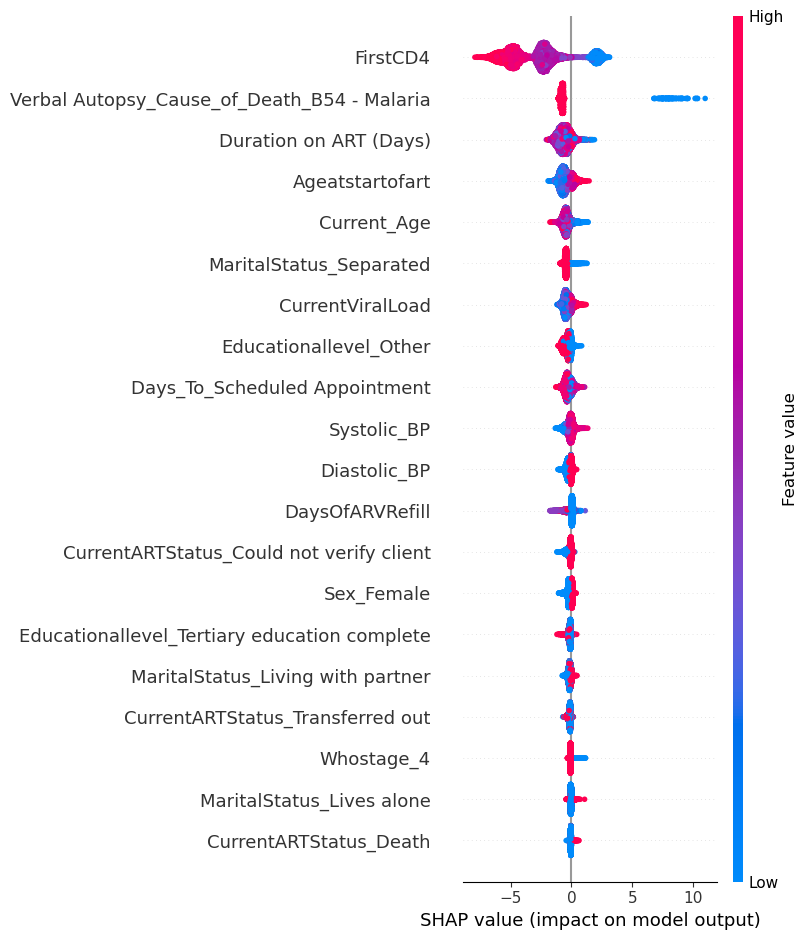

<Figure size 640x480 with 0 Axes>

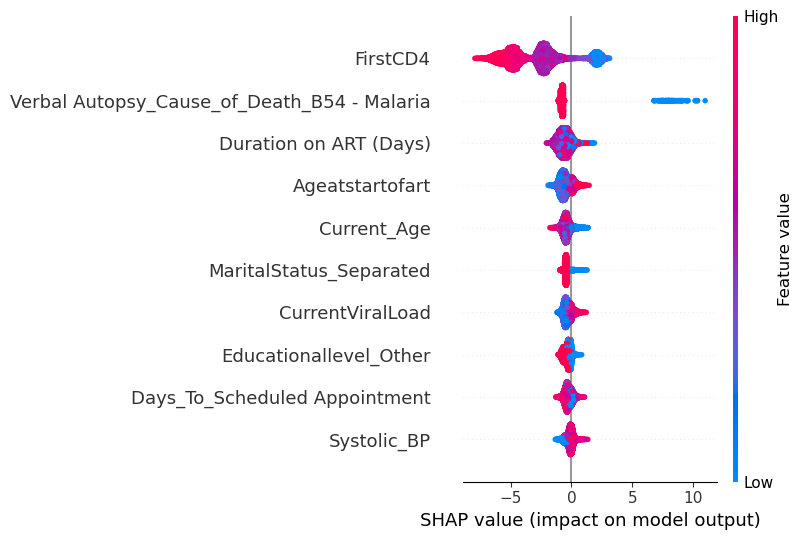

<Figure size 640x480 with 0 Axes>

Feature importance and SHAP plots have been saved.


<Figure size 640x480 with 0 Axes>

In [201]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming your best_xgb model is trained and X_test_np is defined (as a NumPy array or DataFrame)
# Map feature names if X_test_np is not a DataFrame
if isinstance(X_test_np, pd.DataFrame):
    feature_names = X_test_np.columns
else:
    feature_names = features_encoded.columns

# SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_np)

# Feature importance (SHAP summary plot)
shap.summary_plot(shap_values, X_test_np, feature_names=feature_names)
plt.tight_layout()
plt.show()  # This will show the SHAP summary plot

# Save the SHAP summary plot to a file
plt.savefig('shap_summary_plot.png')

# Detailed SHAP plot for top 10 features
shap.summary_plot(shap_values, X_test_np, max_display=10, feature_names=feature_names)
plt.tight_layout()
plt.show()  # This will show the detailed SHAP plot

# Save the detailed SHAP plot
plt.savefig('shap_detailed_plot.png')

# Save the feature importance plot to a file
plt.savefig('xgboost_feature_importance.png')

print("Feature importance and SHAP plots have been saved.")


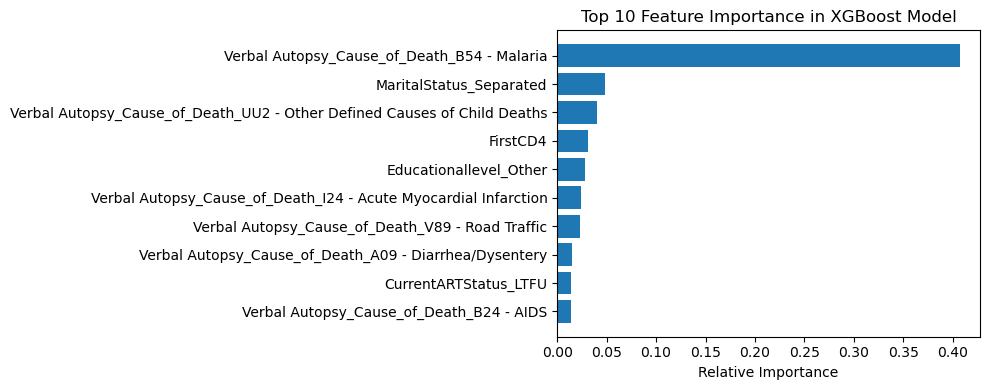

Top 10 most important features:
Verbal Autopsy_Cause_of_Death_B54 - Malaria: 0.40724268555641174
MaritalStatus_Separated: 0.04874419793486595
Verbal Autopsy_Cause_of_Death_UU2 - Other Defined Causes of Child Deaths: 0.0404650904238224
FirstCD4: 0.03157520294189453
Educationallevel_Other: 0.027738792821764946
Verbal Autopsy_Cause_of_Death_I24 - Acute Myocardial Infarction: 0.023708608001470566
Verbal Autopsy_Cause_of_Death_V89 - Road Traffic: 0.02347652241587639
Verbal Autopsy_Cause_of_Death_A09 - Diarrhea/Dysentery: 0.014772184193134308
CurrentARTStatus_LTFU: 0.01402335800230503
Verbal Autopsy_Cause_of_Death_B24 - AIDS: 0.013656777329742908


In [219]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of top features you want to display
top_n = 10

if isinstance(X_test_np, pd.DataFrame):
    feature_names = X_test_np.columns
else:
    feature_names = features_encoded.columns

# Get feature importance and feature names
feature_importance = best_xgb.feature_importances_
feature_names = features_encoded.columns   
# Sort the features by importance in descending order (highest to lowest)
indices = np.argsort(feature_importance)[::-1]  # Sort in descending order
sorted_feature_names = [feature_names[i] for i in indices]

# Select the top N features (highest importance)
top_n_indices = indices[:top_n]  # Get indices of top N features (highest importance)
top_n_feature_names = [feature_names[i] for i in top_n_indices]  # Get names of top N features
top_n_importance = feature_importance[top_n_indices]  # Get importance scores of top N features

# Plot the top N feature importance in descending order
plt.figure(figsize=(10, 4))  # Adjust the size if necessary
plt.title(f"Top {top_n} Feature Importance in XGBoost Model")
plt.barh(range(top_n), top_n_importance, align='center')
plt.yticks(range(top_n), top_n_feature_names, rotation=0, ha="right")
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

# Print the top N feature names and their importance
print(f"Top {top_n} most important features:")
for feature, importance in zip(top_n_feature_names, top_n_importance):
    print(f"{feature}: {importance}")


## Deep Learning Models

#### Multilayer Perceptron (MLP)

In [6]:
pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/385.2 MB 10.5 MB/s eta 0:00:37
   ---------------------------------------- 1.2/385.2 MB 12.6 MB/s eta 0:00:31
   ---------------------------------------- 1.4/385.2 MB 10.0 MB/s eta 0:00:39
   ---------------------------------------- 2.7/385.2 MB 15.4 MB/s eta 0:00:25
   ---------------------------------------- 3.1/385.2 MB 14.3 MB/s eta 0:00:27
   ---------------------------------------- 4.1/385.2 MB 16.4 MB/s eta 0:00:24
    --------------------------------------- 4.8/385.2 MB 16.2 MB/s eta 0:00:24
    --------------------------------------- 5.4/385.2 MB 16.4 MB/s eta 0:00:24
    --------------------------------------- 6.2/385.2 MB 16.5 MB/s eta 0:00:24
    --------------------------------------- 6.9/385.2 MB 16.2 MB/s

In [47]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights (automatically balance based on class frequencies)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define the MLP model with class weights
def create_mlp_with_class_weights():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_resampled_refined.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create and train the MLP model with class weights
mlp_model_weighted = create_mlp_with_class_weights()
mlp_model_weighted.fit(X_train_resampled_refined, y_train_resampled, epochs=20, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weights_dict)

# Predict on the test set
y_proba_mlp_weighted = mlp_model_weighted.predict(X_test_refined).flatten()
y_pred_mlp_weighted = (y_proba_mlp_weighted > 0.5).astype(int)

# Evaluate the model with class weights
accuracy_mlp_weighted = accuracy_score(y_test_refined, y_pred_mlp_weighted)
precision_mlp_weighted = precision_score(y_test_refined, y_pred_mlp_weighted)
recall_mlp_weighted = recall_score(y_test_refined, y_pred_mlp_weighted)
f1_mlp_weighted = f1_score(y_test_refined, y_pred_mlp_weighted)
roc_auc_mlp_weighted = roc_auc_score(y_test_refined, y_proba_mlp_weighted)

# Print evaluation metrics
print("MLP Model with Class Weights Performance:")
print(f"Accuracy: {accuracy_mlp_weighted}")
print(f"Precision: {precision_mlp_weighted}")
print(f"Recall: {recall_mlp_weighted}")
print(f"F1-Score: {f1_mlp_weighted}")
print(f"ROC AUC: {roc_auc_mlp_weighted}")

print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_mlp_weighted))


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7692 - loss: 2.7437 - val_accuracy: 0.8068 - val_loss: 0.4766
Epoch 2/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8498 - loss: 0.3742 - val_accuracy: 0.9029 - val_loss: 0.3080
Epoch 3/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8833 - loss: 0.2967 - val_accuracy: 0.8544 - val_loss: 0.3342
Epoch 4/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9163 - loss: 0.2170 - val_accuracy: 0.8404 - val_loss: 0.3125
Epoch 5/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9280 - loss: 0.1840 - val_accuracy: 0.9399 - val_loss: 0.1279
Epoch 6/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9366 - loss: 0.1620 - val_accuracy: 0.9559 - val_loss: 0.1216
Epoch 7/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9278 - loss: 0.1745 - val_accuracy: 0.9643 - val_loss: 0.0850
Epoch 8/20
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9255 - loss: 0.1810 - 

In [53]:
import tensorflow as tf
import numpy as np
import random
import os

# Function to set random seeds for reproducibility
def set_random_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Set seed before training the model
set_random_seed(42)

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np

# Set random seed
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Define the MLP model with class weights and slightly adjusted architecture
def create_mlp_optimized():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_resampled_refined.shape[1], activation='relu'))
    model.add(Dropout(0.4))  # High dropout to prevent overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    return model

# Create the optimized MLP model
mlp_model_optimized = create_mlp_optimized()

# Set early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the MLP model with early stopping and class weights
mlp_model_optimized.fit(X_train_resampled_refined, y_train_resampled, epochs=50, batch_size=16, 
                        validation_split=0.2, verbose=1, class_weight=class_weights_dict, 
                        callbacks=[early_stopping])

# Predict on the test set
y_proba_mlp_optimized = mlp_model_optimized.predict(X_test_refined).flatten()

# Fine-tune the decision threshold
threshold = 0.48  # Experiment with slight changes around this (e.g., 0.42 to 0.48)
y_pred_mlp_optimized = (y_proba_mlp_optimized > threshold).astype(int)

# Evaluate the optimized MLP model
accuracy_mlp_optimized = accuracy_score(y_test_refined, y_pred_mlp_optimized)
precision_mlp_optimized = precision_score(y_test_refined, y_pred_mlp_optimized)
recall_mlp_optimized = recall_score(y_test_refined, y_pred_mlp_optimized)
f1_mlp_optimized = f1_score(y_test_refined, y_pred_mlp_optimized)
roc_auc_mlp_optimized = roc_auc_score(y_test_refined, y_proba_mlp_optimized)

# Print evaluation metrics
print("Optimized MLP Model Performance:")
print(f"Accuracy: {accuracy_mlp_optimized}")
print(f"Precision: {precision_mlp_optimized}")
print(f"Recall: {recall_mlp_optimized}")
print(f"F1-Score: {f1_mlp_optimized}")
print(f"ROC AUC: {roc_auc_mlp_optimized}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_mlp_optimized))


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7486 - loss: 5.0918 - val_accuracy: 0.7785 - val_loss: 0.5193
Epoch 2/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8473 - loss: 0.4050 - val_accuracy: 0.8247 - val_loss: 0.4188
Epoch 3/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8705 - loss: 0.3363 - val_accuracy: 0.9234 - val_loss: 0.2285
Epoch 4/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9104 - loss: 0.2322 - val_accuracy: 0.9349 - val_loss: 0.1546
Epoch 5/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9278 - loss: 0.1841 - val_accuracy: 0.8925 - val_loss: 0.2334
Epoch 6/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9354 - loss: 0.1684 - val_accuracy: 0.9693 - val_loss: 0.0938
Epoch 7/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9371 - loss: 0.1626 - val_accuracy: 0.9437 - val_loss: 0.1177
Epoch 8/50
5268/5268 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9399 - loss: 0

#### CNN with Tabular Data

In [110]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Set random seed for reproducibility
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train_resampled_refined, y_train_resampled)

# Define the CNN model with class weights and standard cross-entropy loss
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(X_train_cnn.shape[1], 1)))  # Input layer to avoid warnings
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert the data from DataFrame to NumPy array and ensure it's float32
X_train_np = X_train_resampled_smote.to_numpy().astype('float32')
X_test_np = X_test_refined.to_numpy().astype('float32')

# Reshape input data for 1D CNN (NumPy array with shape [samples, features, 1])
X_train_cnn = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_cnn = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

# Class weights to handle imbalance
class_weights = {0: 1, 1: len(y_train_resampled_smote) / sum(y_train_resampled_smote)}  # Calculate class weights

# Create CNN model
cnn_model = create_cnn_model()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN model with class weights
cnn_model.fit(X_train_cnn, y_train_resampled_smote, epochs=30, batch_size=32, validation_split=0.2, 
              class_weight=class_weights, verbose=1, callbacks=[early_stopping])

# Predict on test data
y_proba_cnn = cnn_model.predict(X_test_cnn).flatten()
y_pred_cnn = (y_proba_cnn > 0.47).astype(int)

# Evaluate the CNN model
accuracy_cnn = accuracy_score(y_test_refined, y_pred_cnn)
precision_cnn = precision_score(y_test_refined, y_pred_cnn)
recall_cnn = recall_score(y_test_refined, y_pred_cnn)
f1_cnn = f1_score(y_test_refined, y_pred_cnn)
roc_auc_cnn = roc_auc_score(y_test_refined, y_proba_cnn)

# Print evaluation metrics
print("Improved CNN Model Performance with SMOTE and Class Weights:")
print(f"Accuracy: {accuracy_cnn}")
print(f"Precision: {precision_cnn}")
print(f"Recall: {recall_cnn}")
print(f"F1-Score: {f1_cnn}")
print(f"ROC AUC: {roc_auc_cnn}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_cnn))


Epoch 1/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.7911 - loss: 0.6637 - val_accuracy: 0.8293 - val_loss: 0.3594
Epoch 2/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.8448 - loss: 0.5272 - val_accuracy: 0.8251 - val_loss: 0.3436
Epoch 3/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.9103 - loss: 0.2779 - val_accuracy: 0.8786 - val_loss: 0.2092
Epoch 4/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9297 - loss: 0.2221 - val_accuracy: 0.7260 - val_loss: 0.4373
Epoch 5/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9372 - loss: 0.2069 - val_accuracy: 0.9402 - val_loss: 0.0971
Epoch 6/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.9472 - loss: 0.1812 - val_accuracy: 0.9545 - val_loss: 0.0725
Epoch 8/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9530 - loss: 0.1717 - val_accuracy: 0.9317 - val_loss: 0.1250
Epoch 9/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9527 -

#### RNN LSTM Model

In [127]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Set random seed for reproducibility
def set_random_seed(seed_value=42):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train_resampled_refined.to_numpy().astype('float32'), y_train_resampled.to_numpy().astype('float32'))

# Reshape input data for LSTM (NumPy array with shape [samples, timesteps, features])
X_train_lstm = X_train_resampled_smote.reshape((X_train_resampled_smote.shape[0], 1, X_train_resampled_smote.shape[1]))
X_test_lstm = X_test_refined.to_numpy().astype('float32').reshape((X_test_refined.shape[0], 1, X_test_refined.shape[1]))

# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(1, X_train_lstm.shape[2])))  # LSTM Layer
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create LSTM model
lstm_model = create_lstm_model()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the LSTM model with class weights
class_weights = {0: 1, 1: 2.0}  # Adjust class weights
lstm_model.fit(X_train_lstm, y_train_resampled_smote, epochs=30, batch_size=32, validation_split=0.2,
               class_weight=class_weights, verbose=1, callbacks=[early_stopping])

# Predict on the test data
y_proba_lstm = lstm_model.predict(X_test_lstm).flatten()
y_pred_lstm = (y_proba_lstm > 0.45).astype(int)

# Evaluate the LSTM model
accuracy_lstm = accuracy_score(y_test_refined, y_pred_lstm)
precision_lstm = precision_score(y_test_refined, y_pred_lstm)
recall_lstm = recall_score(y_test_refined, y_pred_lstm)
f1_lstm = f1_score(y_test_refined, y_pred_lstm)
roc_auc_lstm = roc_auc_score(y_test_refined, y_proba_lstm)

# Print evaluation metrics
print("LSTM Model Performance:")
print(f"Accuracy: {accuracy_lstm}")
print(f"Precision: {precision_lstm}")
print(f"Recall: {recall_lstm}")
print(f"F1-Score: {f1_lstm}")
print(f"ROC AUC: {roc_auc_lstm}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_lstm))


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.8295 - loss: 0.5684 - val_accuracy: 0.8747 - val_loss: 0.3023
Epoch 2/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8473 - loss: 0.5103 - val_accuracy: 0.9699 - val_loss: 0.1540
Epoch 3/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8724 - loss: 0.4050 - val_accuracy: 0.9821 - val_loss: 0.0536
Epoch 4/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9154 - loss: 0.2916 - val_accuracy: 0.9991 - val_loss: 0.0050
Epoch 5/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9208 - loss: 0.2799 - val_accuracy: 0.9955 - val_loss: 0.0134
Epoch 6/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9211 - loss: 0.2689 - val_accuracy: 0.9935 - val_loss: 0.0198
Epoch 7/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9260 - loss: 0.2640 - val_accuracy: 0.9999 - val_loss: 0.0013
Epoch 8/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9224 - loss: 0

#### Transformer Model

In [139]:
from tensorflow.keras.regularizers import l2

# Define the updated transformer model with L2 regularization
def create_transformer_model():
    inputs = Input(shape=(1, X_train_transformer.shape[2]))

    # Multi-head attention layer
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    attention = LayerNormalization()(attention)

    # Flatten to remove the sequence/timestep dimension
    flat = Flatten()(attention)

    # Feed-forward layers with L2 regularization
    dense_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(flat)
    dropout_1 = Dropout(0.3)(dense_1)

    dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)

    outputs = Dense(1, activation='sigmoid')(dropout_2)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create transformer model with L2 regularization
transformer_model = create_transformer_model()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Lower class weight for minority class
class_weights = {0: 1, 1: 1.1}

# Train the model
transformer_model.fit(X_train_transformer, y_train_resampled_smote, epochs=30, batch_size=32, validation_split=0.2,
                      class_weight=class_weights, verbose=1, callbacks=[early_stopping])

# Predict on the test data with different thresholds
thresholds = [0.5, 0.55, 0.6]
for threshold in thresholds:
    y_proba_transformer = transformer_model.predict(X_test_transformer).flatten()
    y_pred_transformer = (y_proba_transformer > threshold).astype(int)

    # Evaluate the transformer model
    accuracy_transformer = accuracy_score(y_test_refined, y_pred_transformer)
    precision_transformer = precision_score(y_test_refined, y_pred_transformer)
    recall_transformer = recall_score(y_test_refined, y_pred_transformer)
    f1_transformer = f1_score(y_test_refined, y_pred_transformer)
    roc_auc_transformer = roc_auc_score(y_test_refined, y_proba_transformer)

    # Print evaluation metrics for each threshold
    print(f"\nTransformer Model Performance with Threshold {threshold}:")
    print(f"Accuracy: {accuracy_transformer}")
    print(f"Precision: {precision_transformer}")
    print(f"Recall: {recall_transformer}")
    print(f"F1-Score: {f1_transformer}")
    print(f"ROC AUC: {roc_auc_transformer}")
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test_refined, y_pred_transformer))


Epoch 1/30


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2634/2634 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.8548 - loss: 0.7431 - val_accuracy: 0.9726 - val_loss: 0.0897
Epoch 2/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9391 - loss: 0.1865 - val_accuracy: 0.8764 - val_loss: 0.3415
Epoch 3/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9459 - loss: 0.1660 - val_accuracy: 0.9184 - val_loss: 0.1680
Epoch 4/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.9443 - loss: 0.1686 - val_accuracy: 0.9318 - val_loss: 0.1462
Epoch 5/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9519 - loss: 0.1442 - val_accuracy: 0.9630 - val_loss: 0.0935
Epoch 6/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9493 - loss: 0.1495 - val_accuracy: 0.9853 - val_loss: 0.0458
Epoch 7/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9500 - loss: 0.1533 - val_accuracy: 0.9681 - val_loss: 0.0754
Epoch 8/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.9494 - loss: 0.15

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Transformer Model Performance with Threshold 0.5:
Accuracy: 0.9583394562821455
Precision: 0.3773006134969325
Recall: 0.6044226044226044
F1-Score: 0.46458923512747874
ROC AUC: 0.9352284986231815

Classification Report:

              precision    recall  f1-score   support

       False       0.99      0.97      0.98     13203
        True       0.38      0.60      0.46       407

    accuracy                           0.96     13610
   macro avg       0.68      0.79      0.72     13610
weighted avg       0.97      0.96      0.96     13610

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Transformer Model Performance with Threshold 0.55:
Accuracy: 0.9638501102130786
Precision: 0.42173112338858193
Recall: 0.5626535626535627
F1-Score: 0.48210526315789476
ROC AUC: 0.9352284986231815

Classification Report:

              precision    recall  f1-score   support

       False       0.99      0.98      0.98     13203
        True       0.42      0.56      0

In [159]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping

# Define the simplified hyperparameter grid with two learning rates
param_grid = {
    'num_heads': [2],           # Single value to reduce combinations
    'key_dim': [64],            # Single value
    'dropout_rate_1': [0.2],    # Single value
    'dropout_rate_2': [0.2],    # Single value
    'dense_units_1': [128],     # Single value
    'learning_rate': [0.001, 0.0005]  # Two learning rates to test
}

best_f1 = 0
best_params = None

# Early stopping to avoid overfitting and save time
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Loop over the grid to find the best parameters
for params in ParameterGrid(param_grid):
    transformer_model = create_transformer_model(
        num_heads=params['num_heads'],
        key_dim=params['key_dim'],
        dropout_rate_1=params['dropout_rate_1'],
        dropout_rate_2=params['dropout_rate_2'],
        dense_units_1=params['dense_units_1'],
        learning_rate=params['learning_rate']
    )

    # Train with fewer epochs and a smaller batch size
    transformer_model.fit(X_train_transformer, y_train_resampled_smote, epochs=3, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Evaluate F1-score
    y_proba_transformer = transformer_model.predict(X_test_transformer).flatten()
    y_pred_transformer = (y_proba_transformer > 0.5).astype(int)
    f1 = f1_score(y_test_refined, y_pred_transformer)

    # Update best parameters if the F1-score improves
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

# Print the best hyperparameters and F1-score
print(f"Best Hyperparameters: {best_params}")
print(f"Best F1-Score: {best_f1}")


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  1/426 ━━━━━━━━━━━━━━━━━━━━ 1:46 250ms/step

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 33/426 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step    

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Best Hyperparameters: {'dense_units_1': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'key_dim': 64, 'learning_rate': 0.0005, 'num_heads': 2}
Best F1-Score: 0.5033647375504711


In [161]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Function to create the best transformer model based on tuned hyperparameters
def create_optimized_transformer_model():
    inputs = Input(shape=(1, X_train_transformer.shape[2]))  # Adjusted input for transformer model

    # Multi-head attention layer with optimal number of heads and key dimension
    attention = MultiHeadAttention(num_heads=2, key_dim=64)(inputs, inputs)
    attention = LayerNormalization()(attention)

    # Flatten to remove extra dimensions
    flat = Flatten()(attention)

    # Optimized Dense layers with regularization and dropout
    dense_1 = Dense(128, activation='relu', kernel_regularizer='l2')(flat)
    dropout_1 = Dropout(0.2)(dense_1)

    dense_2 = Dense(64, activation='relu', kernel_regularizer='l2')(dropout_1)
    dropout_2 = Dropout(0.2)(dense_2)

    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(dropout_2)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the optimized transformer model
transformer_model = create_optimized_transformer_model()

# Train the model with fewer epochs and a smaller batch size to ensure runtime within 3-5 minutes
transformer_model.fit(X_train_transformer, y_train_resampled_smote, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Predict on the test set
y_proba_transformer = transformer_model.predict(X_test_transformer).flatten()
y_pred_transformer = (y_proba_transformer > 0.5).astype(int)

# Evaluate the optimized model
accuracy_transformer = accuracy_score(y_test_refined, y_pred_transformer)
precision_transformer = precision_score(y_test_refined, y_pred_transformer)
recall_transformer = recall_score(y_test_refined, y_pred_transformer)
f1_transformer = f1_score(y_test_refined, y_pred_transformer)
roc_auc_transformer = roc_auc_score(y_test_refined, y_proba_transformer)

# Print evaluation metrics
print("Optimized Transformer Model Performance:")
print(f"Accuracy: {accuracy_transformer}")
print(f"Precision: {precision_transformer}")
print(f"Recall: {recall_transformer}")
print(f"F1-Score: {f1_transformer}")
print(f"ROC AUC: {roc_auc_transformer}")

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test_refined, y_pred_transformer))


Epoch 1/5


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2634/2634 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.8562 - loss: 0.8583 - val_accuracy: 0.7859 - val_loss: 0.4015
Epoch 2/5
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.9351 - loss: 0.1765 - val_accuracy: 0.9149 - val_loss: 0.1924
Epoch 3/5
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9479 - loss: 0.1492 - val_accuracy: 0.9424 - val_loss: 0.1239
Epoch 4/5
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.9518 - loss: 0.1384 - val_accuracy: 0.9408 - val_loss: 0.1415
Epoch 5/5
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9533 - loss: 0.1331 - val_accuracy: 0.8758 - val_loss: 0.3146
 33/426 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step    

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimized Transformer Model Performance:
Accuracy: 0.9745775165319618
Precision: 0.6548223350253807
Recall: 0.31695331695331697
F1-Score: 0.4271523178807947
ROC AUC: 0.9386444447794141

Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     13203
        True       0.65      0.32      0.43       407

    accuracy                           0.97     13610
   macro avg       0.82      0.66      0.71     13610
weighted avg       0.97      0.97      0.97     13610



## SHAP for the Best Model - XGBoost

In [212]:
pip install shap

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ------ --------------------------------- 71.7/456.2 kB 2.0 MB/s eta 0:00:01
   ------------------ --------------------- 215.0/456.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
